# 1. Imports and Configuration

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Plot Styling

In [11]:
# Configure the plotting style for enhanced visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


# 3. File's paths

In [12]:
# Define file paths
path_gdp = '../data/pib_trimestral.csv'
path_corp_credit = '../data/credito_empresas.csv'
path_household_credit = '../data/credito_particulares.csv'
path_debt = '../data/endividamento_setor_devedor.csv'

# Attempt to load the CSV files using 'latin1' encoding
# This encoding avoids issues with special characters (e.g., ç in Portuguese datasets)
try:
    df_gdp = pd.read_csv(path_gdp, sep=';', encoding='latin1')
    df_corp_credit = pd.read_csv(path_corp_credit, sep=';', encoding='latin1')
    df_household_credit = pd.read_csv(path_household_credit, sep=';', encoding='latin1')
    df_debt = pd.read_csv(path_debt, sep=';', encoding='latin1')

    print("CSV files successfully loaded (encoding='latin1').")
    print("GDP:", df_gdp.shape)
    print("Corporate Credit:", df_corp_credit.shape)
    print("Household Credit:", df_household_credit.shape)
    print("Debt:", df_debt.shape)

    df_gdp.head()

except Exception as e:
    print(f"An error occurred: {e}")
    print("Try using 'windows-1252' if 'latin1' does not work.")


CSV files successfully loaded (encoding='latin1').
GDP: (89, 7)
Corporate Credit: (269, 7)
Household Credit: (269, 7)
Debt: (181, 7)


# 4. Dataframe Processing

In [13]:
def process_dataframe(df, col_date='Período de referência', col_value='Valor'):
    """
    Function to preprocess the DataFrames:
    1. Selects only the date and value columns.
    2. Converts the date column to datetime format.
    3. Removes rows where the value is null or non-numeric.
    4. Sets the date as the index.
    5. Sorts the index.
    """
    
    # 1. Select only the relevant columns
    df_clean = df[[col_date, col_value]].copy()
    
    # 2. Rename columns to simpler names
    df_clean.rename(columns={col_date: 'Date', col_value: 'Value'}, inplace=True)

    # 3. Convert the date column to datetime
    df_clean['Date'] = pd.to_datetime(df_clean['Date'])
    
    # 4. Convert the value column to numeric, handling errors
    # BPstat sometimes uses '...' for missing values; to_numeric deals with this.
    df_clean['Value'] = pd.to_numeric(df_clean['Value'], errors='coerce')
    df_clean.dropna(subset=['Value'], inplace=True)

    # 5. Set the date column as the index
    df_clean.set_index('Date', inplace=True)
    
    # 6. Sort the index
    df_clean.sort_index(inplace=True)
    
    return df_clean

# Apply the processing function to each DataFrame
df_gdp_proc = process_dataframe(df_gdp)
df_corp_credit_proc = process_dataframe(df_corp_credit)
df_household_credit_proc = process_dataframe(df_household_credit)
df_debt_proc = process_dataframe(df_debt)

print("All DataFrames processed successfully.")
print("\nSample of the processed GDP DataFrame:")
display(df_gdp_proc.head())
print("\nDataFrame info:")
df_gdp_proc.info()


All DataFrames processed successfully.

Sample of the processed GDP DataFrame:


,Value
Date,
2003-03-31,-1.6
2003-06-30,-1.9
2003-09-30,-0.6
2003-12-31,0.4
2004-03-31,1.3



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 89 entries, 2003-03-31 to 2025-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   89 non-null     float64
dtypes: float64(1)
memory usage: 1.4 KB


# 5. Macroeconomic Time Series Visualization

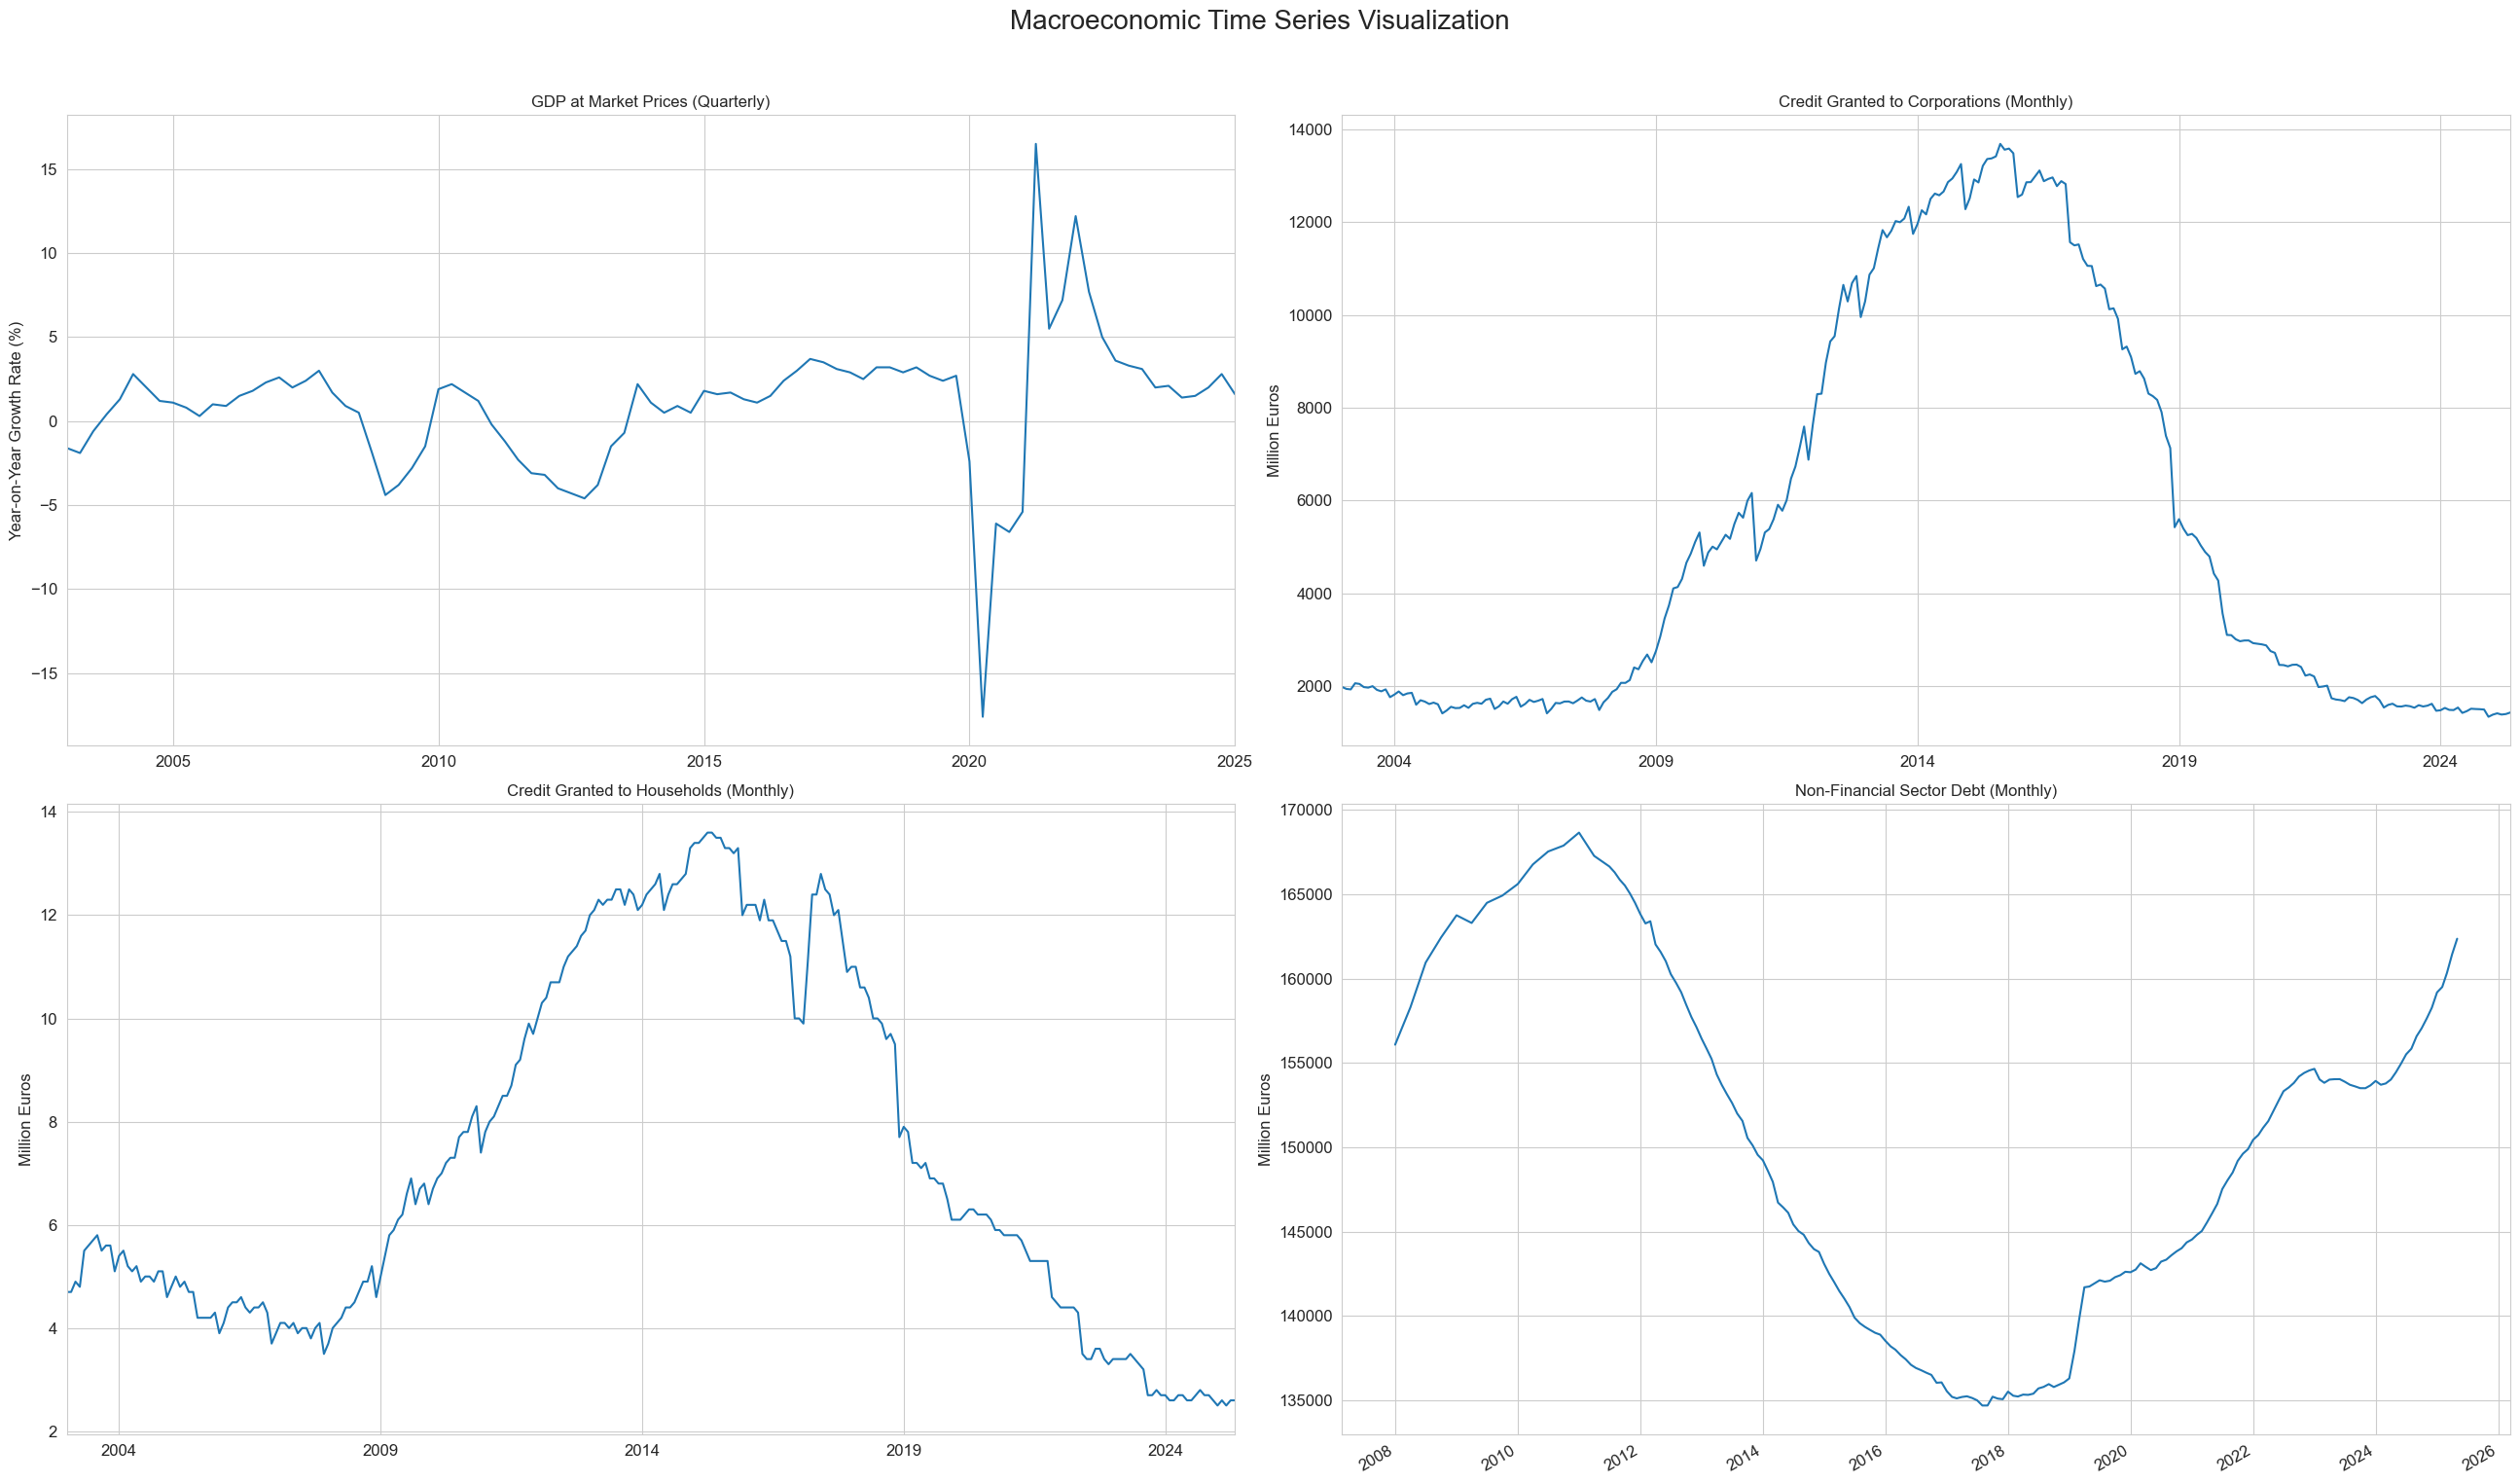

In [14]:
# Figura com 4 subplots (2x2) – versão maior
fig, axes = plt.subplots(2, 2, figsize=(26, 16))  # Aumentado
fig.suptitle('Macroeconomic Time Series Visualization', fontsize=20)

# Plot 1: Quarterly GDP
df_gdp_proc['Value'].plot(ax=axes[0, 0], title='GDP at Market Prices (Quarterly)', fontsize=12)
axes[0, 0].set_ylabel('Year-on-Year Growth Rate (%)', fontsize=12)
axes[0, 0].set_xlabel('')

# Plot 2: Credit to Corporations
df_corp_credit_proc['Value'].plot(ax=axes[0, 1], title='Credit Granted to Corporations (Monthly)', fontsize=12)
axes[0, 1].set_ylabel('Million Euros', fontsize=12)
axes[0, 1].set_xlabel('')

# Plot 3: Credit to Households
df_household_credit_proc['Value'].plot(ax=axes[1, 0], title='Credit Granted to Households (Monthly)', fontsize=12)
axes[1, 0].set_ylabel('Million Euros', fontsize=12)
axes[1, 0].set_xlabel('')

# Plot 4: Non-Financial Sector Debt
df_debt_proc['Value'].plot(ax=axes[1, 1], title='Non-Financial Sector Debt (Monthly)', fontsize=12)
axes[1, 1].set_ylabel('Million Euros', fontsize=12)
axes[1, 1].set_xlabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


- GDP shows a clear drop around 2020 followed by a sharp rebound, which reflects the COVID-19 shock and recovery. Before and after that period, the series moves within a more stable range.

- Credit to corporations rises steadily until around 2016, then stabilises, and later declines sharply after 2018. This pattern suggests a long credit expansion phase followed by a period of contraction.

- Credit to households increases gradually until mid-2013s, stays elevated for a while, and then drops consistently from 2018 onward, showing weaker demand or tighter lending conditions.

- Non-financial sector debt peaks around 2011, decreases for several years, and starts rising again after 2019, indicating renewed debt accumulation in the aftermath of the pandemic.

#  6. Value Normalization and Dataframe merging

In [15]:
# 1. Downsample monthly series to quarterly ('QE')
# Downsampling is preferable to upsampling because it preserves real observed data,
# whereas upsampling would generate artificial values not present in reality.

# For credit series, aggregate using the quarterly sum.
# Pandas aligns quarters to the period end (Mar, Jun, Sep, Dec) automatically.
df_corp_credit_q = df_corp_credit_proc.resample('QE').sum()
df_household_credit_q = df_household_credit_proc.resample('QE').sum()

# For debt (stock variable), take the last observed value in each quarter.
df_debt_q = df_debt_proc.resample('QE').last()

print("Monthly-to-quarterly resampling completed.")

# 2. Merge all (already quarterly) series into a single DataFrame
df_final = pd.concat([
    df_gdp_proc,
    df_corp_credit_q,
    df_household_credit_q,
    df_debt_q
], axis=1)  # axis=1 merges them as columns

# 3. Rename columns for clarity
df_final.columns = [
    'GDP_YoY_Growth',
    'Total_Corporate_Credit',
    'Total_Household_Credit',
    'Total_Debt'
]

# 4. Drop rows containing missing values (NaN)
# This may occur if the time ranges do not perfectly overlap.
# For example, GDP is quarterly but credit is monthly; the aggregation may create misaligned periods.
df_final.dropna(inplace=True)

print("\nUnified final DataFrame created successfully.")
print("\nFirst rows of the final DataFrame:")
display(df_final.head())

print("\nLast rows of the final DataFrame:")
display(df_final.tail())

print("\nFinal DataFrame info:")
df_final.info()


Monthly-to-quarterly resampling completed.

Unified final DataFrame created successfully.

First rows of the final DataFrame:


,GDP_YoY_Growth,Total_Corporate_Credit,Total_Household_Credit,Total_Debt
Date,,,,
2007-12-31,3.0,4877.6,11.6,156083.31
2008-03-31,1.7,5278.5,11.8,158296.02
2008-06-30,0.9,6077.3,13.0,160952.95
2008-09-30,0.5,6898.4,14.1,162444.83
2008-12-31,-1.9,7738.9,14.7,163756.38



Last rows of the final DataFrame:


,GDP_YoY_Growth,Total_Corporate_Credit,Total_Household_Credit,Total_Debt
Date,,,,
2024-03-31,1.4,4503.1,7.9,154016.14
2024-06-30,1.5,4449.8,8.0,155512.53
2024-09-30,2.0,4483.6,8.1,157050.30
2024-12-31,2.8,4341.9,8.0,159183.62
2025-03-31,1.6,4191.2,7.6,161447.65



Final DataFrame info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70 entries, 2007-12-31 to 2025-03-31
Freq: QE-DEC
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   GDP_YoY_Growth          70 non-null     float64
 1   Total_Corporate_Credit  70 non-null     float64
 2   Total_Household_Credit  70 non-null     float64
 3   Total_Debt              70 non-null     float64
dtypes: float64(4)
memory usage: 2.7 KB


#  7. Correlation Matrix

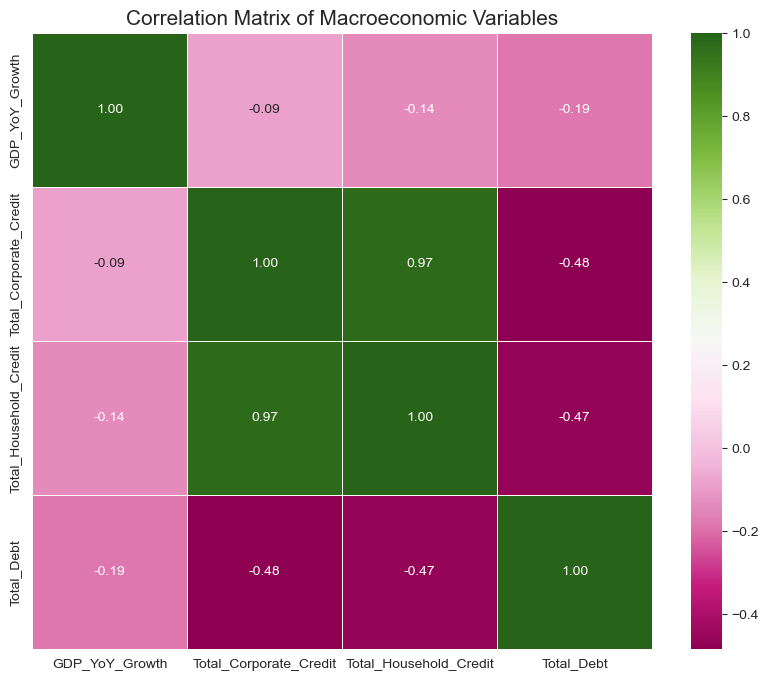


Correlation Matrix:


,GDP_YoY_Growth,Total_Corporate_Credit,Total_Household_Credit,Total_Debt
GDP_YoY_Growth,1.000000,-0.085225,-0.138561,-0.188631
Total_Corporate_Credit,-0.085225,1.000000,0.974387,-0.484638
Total_Household_Credit,-0.138561,0.974387,1.000000,-0.465495
Total_Debt,-0.188631,-0.484638,-0.465495,1.000000


In [16]:
# 1. Compute the correlation matrix of the final DataFrame
correlation_matrix = df_final.corr()

# 2. Visualize the correlation matrix using a heatmap for easier interpretation
plt.figure(figsize=(10, 8))  # Adjust figure size
sns.heatmap(
    correlation_matrix,
    annot=True,        # Display correlation values inside each cell
    cmap='PiYG',       # Diverging color map (green for positive, pink for negative)
    fmt=".2f",         # Format numbers with two decimal places
    linewidths=.5      # Add lines between cells for better readability
)

plt.title('Correlation Matrix of Macroeconomic Variables', fontsize=15)
plt.show()

# Display the correlation matrix as plain text as well
print("\nCorrelation Matrix:")
display(correlation_matrix)


- GDP has very weak correlations with the other variables (around −0.09 to −0.19). This is expected because GDP fluctuates more from quarter to quarter, while credit and debt move in steadier long-term trends.

- Corporate credit and household credit have an extremely high correlation of **0.97**, showing that both series move almost identically and are influenced by similar factors.

- Total debt has a moderate negative correlation with credit (around **−0.47**), meaning that higher credit in a given quarter does not always increase debt levels, since repayments or other adjustments can offset new lending.


In [17]:
# --- END OF NOTEBOOK 1: DATA EXPORT ---

# Define the output path for the cleaned quarterly dataset
output_path = '../data/processed_quarterly_data.csv'

# Save the final DataFrame to CSV
# The index (dates) is saved by default, which is exactly what we want
df_final.to_csv(output_path)

print("Exploratory Analysis and Preprocessing completed.")
print(f"The final DataFrame has been successfully saved to: {output_path}")
print("\n--> This notebook can now be saved and closed.")
print("--> The next step is to open '02_anomaly_modeling.ipynb'.")

Exploratory Analysis and Preprocessing completed.
The final DataFrame has been successfully saved to: ../data/processed_quarterly_data.csv

--> This notebook can now be saved and closed.
--> The next step is to open '02_anomaly_modeling.ipynb'.


<div style="text-align: center; margin-top: 20px;">
    <a href="02_anomaly_modeling.ipynb" target="_self">
        <button style="
            background-color:#DAA520;
            border:none;
            color:white;
            padding:14px 28px;
            font-size:16px;
            border-radius:8px;
            cursor:pointer;">
            Open Next Notebook: 02_anomaly_modeling.ipynb ->
        </button>
    </a>
</div>
